<a href="https://colab.research.google.com/github/ajaythakur3369/LetsGrowMore-Internship/blob/main/Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name - Facial Recognition**
## **Developed By - Ajay Thakur (ajaythakur3369@gmail.com)**
## **Branch Name - Electronics and Communication Engineering**
## **Institute Name - Indian Institute of Information Technology Kota**
## **Submitted To - LetsGrowMore**
## **Project Link (GitHub) - [Click here](https://github.com/ajaythakur3369/LetsGrowMore-Internship)**

## **Importing the Libraries**

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [ ]:
# Accessing the drive from Colab to access the file
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_dir = '/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/Folder_Name/Training_dataset/'

In [ ]:
test_dir = '/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/Folder_Name/Testing_dataset/'

In [ ]:
row = 48
col = 48

In [ ]:
classes = len(os.listdir('/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/Folder_Name/Training_dataset'))

In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/Folder_Name/Combined_dataset'))

['Training_dataset', 'Testing_dataset']


In [ ]:
print('Train Directory:')
print(os.listdir('/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/Folder_Name/Training_dataset'))

Train Directory:
['angry', 'surprise', 'fear', 'sad', 'disgust', 'neutral', 'happy']


In [ ]:
print("Test Directory:")
print(os.listdir('/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/Folder_Name/Testing_dataset'))

Test Directory:
['happy', 'surprise', 'sad', 'fear', 'angry', 'neutral', 'disgust']


In [ ]:
def Classes_Count( path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df
Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by = "Train", ascending = False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by = "Test", ascending = False)
print(Train_Count)
print(Test_Count)

          Train
happy      7215
neutral    5035
sad        4940
fear       4137
angry      4005
surprise   3201
disgust     436
          Test
happy     1774
sad       1247
neutral   1243
fear      1024
angry      958
surprise   842
disgust    111


**Plot of the number of images in the training set**

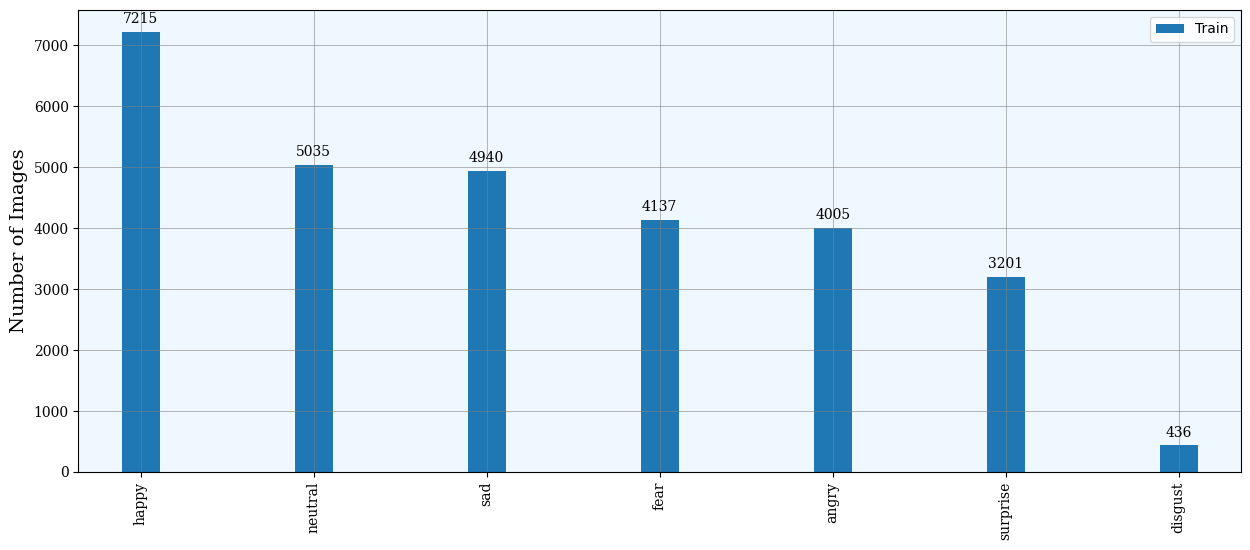

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)
ax = Train_Count.plot(kind = 'bar', width = 0.22)
for g in ax.patches:
    ax.annotate(format(g.get_height(), '0.0f'), (g.get_x() + g.get_width() / 2, g.get_height()), ha = 'center', va = 'center',
                xytext = (0, 9), textcoords = 'offset points', fontname = 'serif')

ax.patch.set_facecolor('aliceblue')
plt.grid(True, color = "grey", linewidth = "0.4")
plt.xticks(fontname = 'serif')
plt.ylabel("Number of Images", fontname = 'serif', fontsize = 14)
plt.yticks(fontname = 'serif')
plt.show()

**Plot of the number of images in the test set**

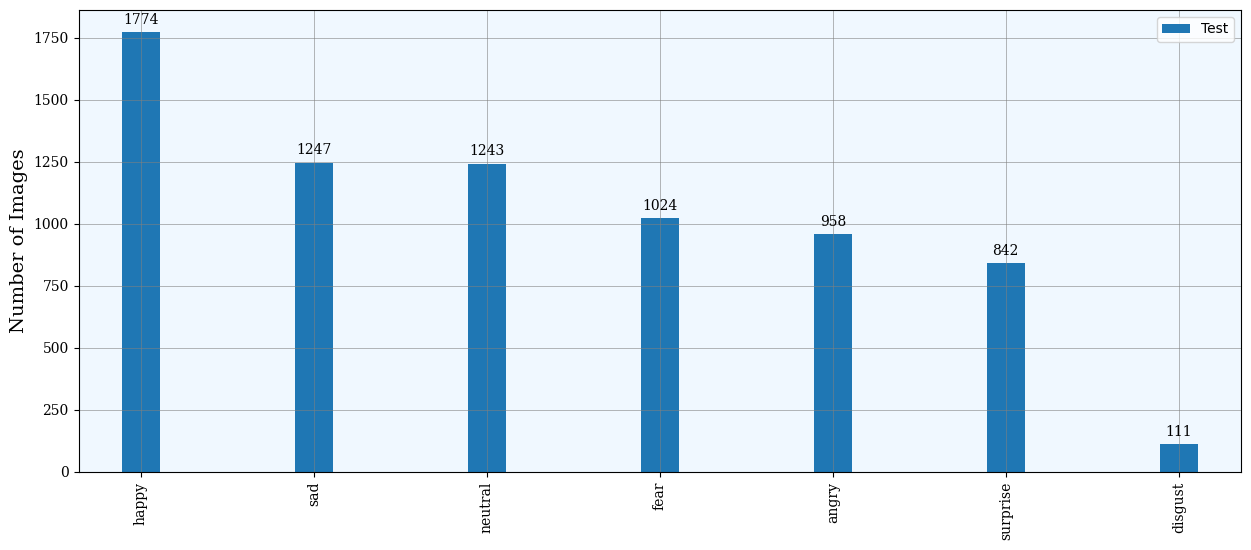

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)
ax = Test_Count.plot(kind = 'bar', width = 0.22)
for g in ax.patches:
    ax.annotate(format(g.get_height(), '0.0f'), (g.get_x() + g.get_width() / 2, g.get_height()), ha = 'center', va = 'center',
                xytext = (0, 9), textcoords = 'offset points', fontname = 'serif')

ax.patch.set_facecolor('aliceblue')
plt.grid(True, color = "grey", linewidth = "0.4")
plt.xticks(fontname = 'serif')
plt.ylabel("Number of Images", fontname = 'serif', fontsize = 14)
plt.yticks(fontname = 'serif')
plt.show()

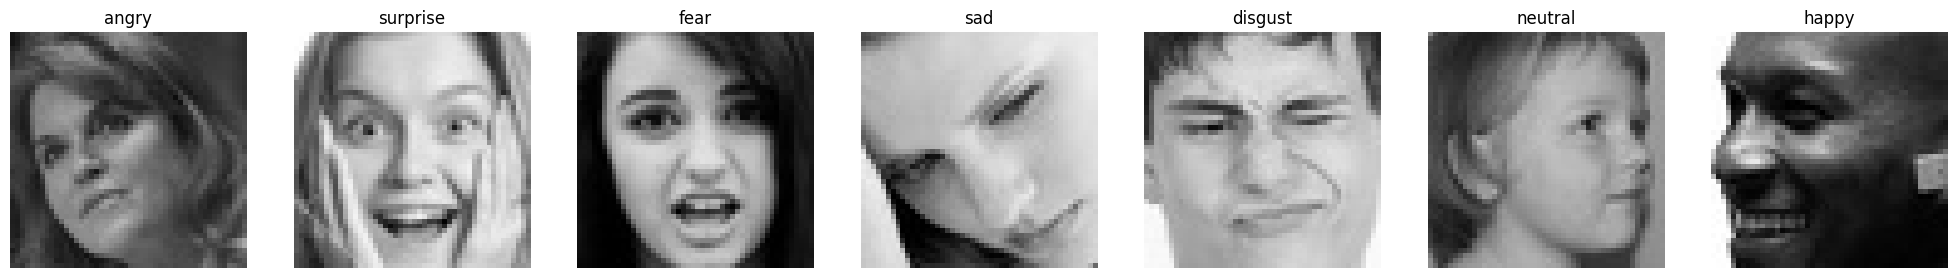

In [ ]:
plt.figure(figsize = (25, 25))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

**Creating training and test sets**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.3,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size = 64,
                                                target_size = (48, 48),
                                                shuffle = True,
                                                color_mode = 'grayscale',
                                                class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size = 64,
                                                target_size = (48, 48),
                                                shuffle = True,
                                                color_mode = 'grayscale',
                                                class_mode = 'categorical')

Found 28969 images belonging to 7 classes.
Found 7199 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

**Defining Model**

In [ ]:
def get_model(input_size, classes = 7):

    # Initialising the CNN
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = input_size))
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size = (3, 3), activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation = 'softmax'))

    # Compiling the model
    learning_rate = 0.001
    momentum = 0.9
    nesterov = True
    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = momentum, nesterov = nesterov)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
fernet = get_model((row, col, 1), classes)

# Adjusting the learning rate as needed
optimizer = Adam(learning_rate = 0.001)
fernet.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

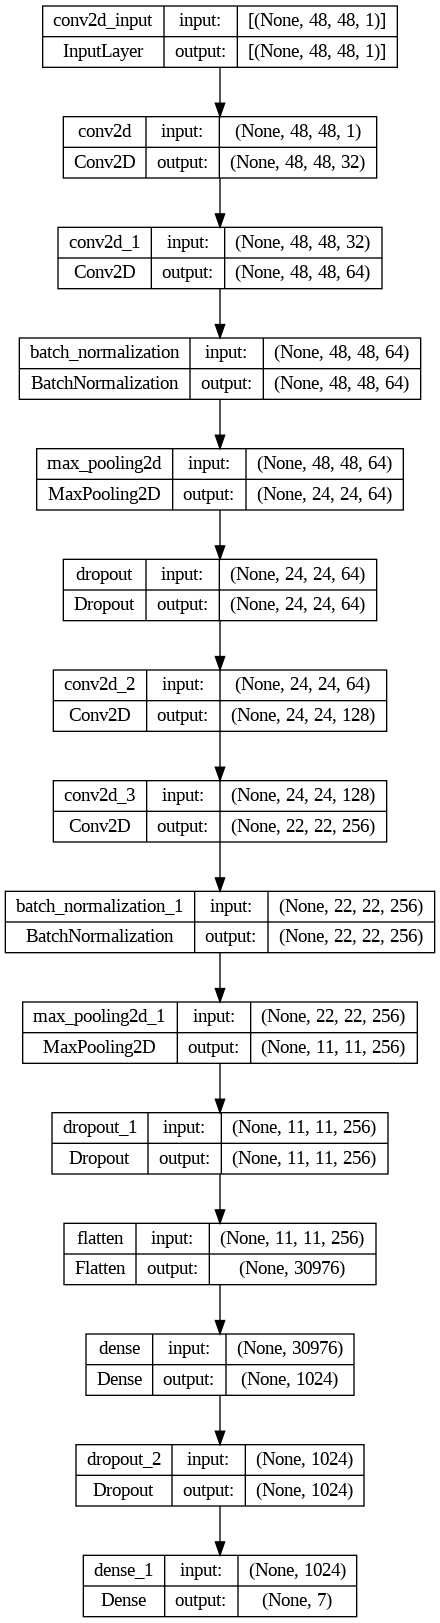

In [ ]:
plot_model(fernet, to_file = '/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/File_Name/Fernet_dataset_image.png', show_shapes = True, show_layer_names = True)

**Callbacks Function**

In [ ]:
chk_path = '/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/File_Name/Fernet_dataset.h5'
log_dir = "/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/Folder_Name/Training_dataset" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath = chk_path,
                             save_best_only = True,
                             verbose = 1,
                             mode = 'min',
                             moniter = 'val_loss')

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/File_Name/Training_dataset.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

**Training Model**

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x = training_set,
                 validation_data = test_set,
                 epochs = 10,
                 callbacks = callbacks,
                 steps_per_epoch = steps_per_epoch,
                 validation_steps = validation_steps)

Epoch 1/10
209/452 [============>.................] - ETA: 1:08:53 - loss: 7.9901 - accuracy: 0.2212

**Loss and Accuracy plot**

In [ ]:
plt.figure(figsize = (14, 5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
plt.figure(figsize = (14, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

**Model Evaluation**

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
fernet.save_weights('/content/drive/MyDrive/Colab_Notebook/Internship_Name/LetsGrowMore/File_Name/Fernet_bestweight_dataset.h5')

**Confusion Matrix and Classification on the training set**

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis = 1)
class_labels = test_set.class_indices
class_labels = {v:k for k, v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names = target_names))

plt.figure(figsize = (8, 8))
class_labels = test_set.class_i = (8, 8)
plt.imshow(cm_train, interpolation = 'nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation = 90)
_ = plt.yticks(tick_mark, target_names)

**Confusion Matrix and Classification on the test set**

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis = 1)
class_labels = test_set.class_indices
class_labels = {v:k for k, v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names = target_names))

plt.figure(figsize = (8, 8))
plt.imshow(cm_test, interpolation = 'nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation = 90)
_ = plt.yticks(tick_mark, target_names)